In [1]:
!pip install opencv-python

You should consider upgrading via the 'c:\users\administrator\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install matplotlib

You should consider upgrading via the 'c:\users\administrator\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install torch

You should consider upgrading via the 'c:\users\administrator\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [4]:
!pip install torchvision

You should consider upgrading via the 'c:\users\administrator\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn

# 1. 이미지 파일 경로 불러오기

In [7]:
image_files = []

# './Covid19-dataset/train/'
# 'Normal'
def list_image_file(data_dir, sub_dir):
    image_format = ['jpeg', 'jpg', 'png']
    image_files = []
    image_dir = os.path.join(data_dir, sub_dir) # './Covid19-dataset/train/Normal'
#     print(image_dir)  
    for file_path in os.listdir(image_dir):
#         print(file_path)
        if file_path.split('.')[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [8]:
data_dir = './Covid19-dataset/train/'
normals_list = list_image_file(data_dir, 'Normal')
covids_list = list_image_file(data_dir, 'Covid')
pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

In [9]:
print(len(normals_list))
print(len(covids_list))
print(len(pneumonias_list))

70
111
70


# 2. 이미지 파일을 RGB 3차원 배열로 불러오기

In [10]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [11]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))
min_num_files

70

In [12]:
@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(131)
    plt.title('Normal')
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title('Covid')
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title('Pneumonia')
    plt.imshow(pneumonia_image)
    plt.tight_layout() # 자동으로 레이아웃을 맞춰주는 함수

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 3. 학습 데이터셋 클래스 만들기
* 데이터셋: 데이터(샘플, 정답)을 저장한 것
* 데이터로더: 데이터셋을 접근하기 쉽게 객체(Iterable)로 감싼 것

In [13]:
train_data_dir = './Covid19-dataset/train/'
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

In [14]:
class Chest_dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        normals = list_image_file(data_dir, 'Normal')
        covids = list_image_file(data_dir, 'Covid')
        pneumonias = list_image_file(data_dir, 'Viral Pneumonia')
        self.files_path = normals + covids + pneumonias
        self.transform = transform
            
    def __len__(self):
        return len(self.files_path)
        
    
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # os.sep: 디렉토리 분리 문자를 리턴(/), Normal/01.jpeg
        target = class_list.index(self.files_path[index].split(os.sep)[-2])
        if self.transform:
            image = self.transform(image)
            target = torch.Tensor([target]).long()

        return {'image':image, 'target':target}          

In [15]:
dset = Chest_dataset(train_data_dir)

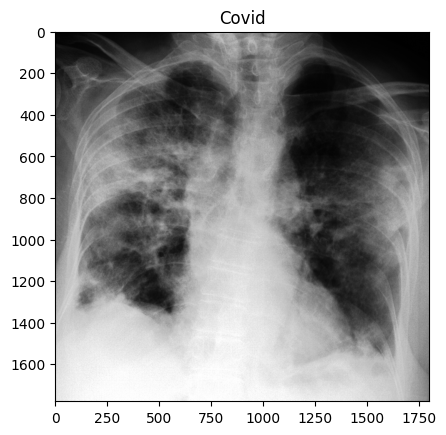

In [16]:
index = 100
plt.title(class_list[dset[index]['target']])
plt.imshow(dset[index]['image'])

# 4. 배열에 연산 가능한 텐서로 변환하기

In [17]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [18]:
train_dset = Chest_dataset(train_data_dir, transformer)

In [19]:
index = 100
image = train_dset[index]['image']
label = train_dset[index]['target']
print(image.shape, label)

torch.Size([3, 224, 224]) tensor([1])


c:\users\administrator\appdata\local\programs\python\python38\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# 5. 데이터 로더 구현하기

In [20]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    # {'train': ..... }
    dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
    val_dset = Chest_dataset(val_data_dir, transformer)
    # {'val': .... }
    dataloaders['val'] = DataLoader(val_dset, batch_size=1, shuffle=False, drop_last=False)
    return dataloaders

In [21]:
train_data_dir = './Covid19-dataset/train/' # 학습 데이터
val_data_dir = './Covid19-dataset/test/' # 테스트 데이터
dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [22]:
for i, d in enumerate(dataloaders['train']):
    print(d)
    if i == 0:
        break

{'image': tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -0.8196,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.8196,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.8196,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -0.8196,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.8196,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.8196,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, 

In [23]:
d['target'].shape

torch.Size([4, 1])

# 6. VGG19(classification) 모델 불러오기
* VGG는 Visual Geometry Group의 약자
* 다중 레이어가 있는 표준 심층 CNN(Convolutional Neural Network) 아키텍처
* 딥"은 16 및 19 컨볼루션 레이어로 구성된 VGG-16 또는 VGG-19가 있는 레이어의 수를 나타냄

<img src="https://wikidocs.net/images/page/164796/vgg_Fig_01.png" width="500px">

In [24]:
# torchvision의 models 사용
# pretrained=True: 미리 학습된 weight들을 가지고 옴
model = models.vgg19(pretrained=True)

In [25]:
# pytorch 모델을 summary 해주는 모듈
!pip install torchsummary

You should consider upgrading via the 'c:\users\administrator\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [26]:
from torchsummary import summary

In [27]:
# Dropout: 오버피팅을 막기 위한 레이어, 학습중일 때 랜덤하게 값을 발생하여 학습을 방해함으로 
# 학습용 데이터에 결과가 치우치는 것을 방지함
summary(model, (3, 224, 224), batch_size=1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

In [28]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# 7. 데이터에 맞게 모델 Head 부분을 수정하기

In [29]:
def build_vgg19_based_model(device_name='cpu'):
    device = torch.device(device_name)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, len(class_list)),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [30]:
model = build_vgg19_based_model(device_name='cpu')

In [31]:
summary(model, (3, 224, 224), batch_size=1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# 8. 손실함수 불러오기
* input x에 대한 예측값과 실제값 사이의 오차를 계산하는 함수
* cost function: 모든 input dataset에 대하여 계산하는 함수

In [32]:
loss_func = nn.CrossEntropyLoss(reduction='mean')

# 9. Gradient 최적화 함수 불러오기

### 9-1. 경사 하강법의 종류
* 배치 경사 하강법
    - 가장 기본적인 경사 하강법(Vanilla Gradeient Descent)
    - 데이터셋 전체를 고려하여 손실함수를 계산
    - 한 번의 Epoch에 모든 파라미터 업데이트를 단 한번만 수행
    - Batch의 갯수와 Iteration은 1이고, Batch size는 전체 데이터의 갯수
    - 파라미터 업데이트할 때 한 번에 전체 데이터셋을 고려하기 때문에 모델 학습 시 많은 시간과 메모리가 필요하다는 단점
    
* 확률적 경사 하강법
    - 확률적 경사 하강법(Stochastic Gradient Descent)은 배치 경사 하강법이 모델 학습 시 많은 시간과 메모리가 필요하다는 단점을 개선하기 위해 제안된 기법
    - Batch size를 1로 설정하여 파라미터를 업데이트 하기 때문에 배치 경사 하강법보다 훨씬 빠르고 적은 메모리로 학습이 진행
    - 파라미터 값의 업데이트 폭이 불안정하기 때문에 정확도가 낮은 경우가 생길 수 있음
    
* 미니 배치 경사 하강법
    - 미니 배치 경사 하강법(Mini-Batch Gradient Descent)은 Batch size가 1도 아니고 전체 데이터 개수도 아닌 경우
    - 일반적으로 Batch size를 32, 64, 128과 같이 2의 n제곱에 해당하는 값으로 설정하는 것이 보편적
    - 딥러닝 분야에서 가장 많이 활용되는 경사 하강법
    - 배치 경사 하강법보다 모델 학습 속도가 빠르고, 확률적 경사 하강법보다 안정적인 장점이 있음

### 9-2. 경사하강법의 여러가지 기술들
* 확률적 경사 하강법(SGD)
    - 매개변수 값을 조정 시 전체 데이터가 아니라 랜덤으로 선택한 하나의 데이터에 대해서만 계산하는 방법 
* 모멘텀(Momentum)
    - 관성이라는 물리학의 법칙을 응용한 방법
    - 경사하강법에 관성을 더 해줌
    - 접선의 기울기에 한 시점 이전의 접선의 기울기값을 일정한 비율만큼 반영
    - 언덕에서 공이 내려올 때 중간의 작은 웅덩이에 빠지더라도 관성의 힘으로 넘어서는 효과를 줄 수 있음
* 아다그라드(Adagrad)
    - 모든 매개변수에 동일한 학습률(learning rate)을 적용하는 것은 비효율적이라는 생각에서 만들어진 학습 방법
    - 처음에는 크게 학습하다가 조금씩 작게 학습시킴
* 아담(Adam)
    - 모멘텀 + 아다그라드

In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

# 10. 모델 검증을 위한 Accuracy 생성하기

In [34]:
@torch.no_grad()
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image)
    _, pred_label = torch.max(prediction, dim=1)
    is_correct = (pred_label == target)
    return is_correct.cpu().numpy().sum() / batch_size

# 11. 모델 학습을 위한 함수 구현하기

In [31]:
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses = {}
    accuracies = {}
    
    for tv in ['train', 'val']:
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train':
            model.train()
        else:
            model.eval()
        
        for index, batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device)
            target = batch['target'].squeeze(dim=1).to(device)
            
            with torch.set_grad_enabled(tv == 'train'):
                prediction = model(image)
                loss = loss_func(prediction, target)
                
                if tv == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
            
            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)
            
                
            if tv == 'train':
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies        

In [32]:
def save_best_model(model_state, model_name, save_dir='./trained_model'):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

# 12. 모델 학습 수행하기

In [39]:
device = torch.device('cpu')

train_data_dir = './Covid19-dataset/train'
val_data_dir = './Covid19-dataset/test'

dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device_name=device)
loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

In [40]:
import copy

In [41]:
num_epochs = 10
best_acc = 0.0
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs} - Train_Loss:{losses['train']}, Val_Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs} - Train_Accuracies:{accuracies['train']}, Val_Accuracies:{accuracies['val']}")

    if(epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict())
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Best Accracy: {best_acc}')

0/62 - Running loss: 1.095841646194458
10/62 - Running loss: 1.085944414138794
20/62 - Running loss: 1.0687891244888306
30/62 - Running loss: 1.1037604808807373
40/62 - Running loss: 1.0598045587539673
50/62 - Running loss: 1.0945589542388916
60/62 - Running loss: 1.046012043952942
1/10 - Train_Loss:1.0763116575056506, Val_Loss:1.0220327693404574
1/10 - Train_Accuracies:0.5241935483870968, Val_Accuracies:0.7272727272727273
0/62 - Running loss: 1.041784644126892
10/62 - Running loss: 0.9826701879501343
20/62 - Running loss: 0.7838401794433594
30/62 - Running loss: 0.814277172088623
40/62 - Running loss: 0.7908036708831787
50/62 - Running loss: 0.7760730981826782
60/62 - Running loss: 0.7585586309432983
2/10 - Train_Loss:0.8293782164973598, Val_Loss:0.7463562949137255
2/10 - Train_Accuracies:0.8185483870967742, Val_Accuracies:0.7575757575757576
0/62 - Running loss: 0.6896694898605347
10/62 - Running loss: 0.7745862603187561
20/62 - Running loss: 1.401180624961853
30/62 - Running loss: 0.

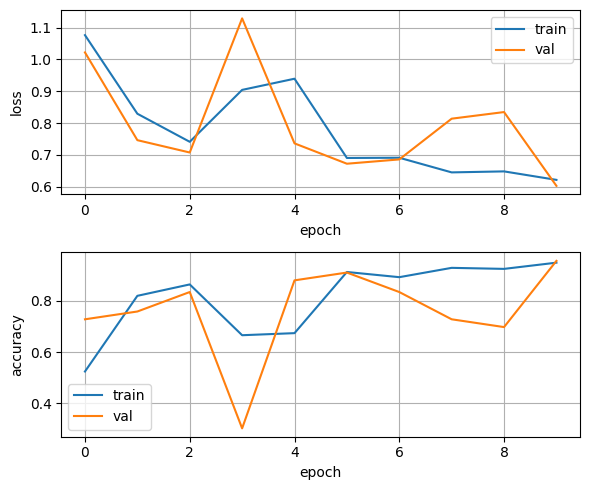

In [42]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid('on')
plt.legend()
plt.subplot(212)
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid('on')
plt.legend()
plt.tight_layout()

In [35]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                            std=[0.5, 0.5, 0.5])
    ])
    
    tensor_image = transformer(image) # C, H, W
    tensor_image = tensor_image.unsqueeze(0) # B, C, H, W
    return tensor_image

In [44]:
def model_predict(image, model):
    tensor_image = preprocess_image(image)
    prediction = model(tensor_image)
    
    _, pred_label = torch.max(prediction.detach(), dim=1)
    print('prediction.detach(): ', prediction.detach())
    print('pred_label: ', pred_label)
    pred_label = pred_label.squeeze(0)
    return pred_label.item()

In [5]:
ckpt = torch.load('./trained_model/model_10.pth')
model = build_vgg19_based_model()
model.load_state_dict(ckpt)
model.eval()

c:\users\administrator\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\administrator\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'class_list' is not defined

In [6]:
data_dir = './Covid19-dataset/test/'
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

test_normals_list = list_image_file(data_dir, 'Normal')
test_covids_list = list_image_file(data_dir, 'Covid')
test_pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

NameError: name 'list_image_file' is not defined

In [50]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))

@interact(index=(0, min_num_files-1))
def show_result(index=0):
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    prediction_1 = model_predict(normal_image, model)
    prediction_2 = model_predict(covid_image, model)
    prediction_3 = model_predict(pneumonia_image, model)
    
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(131)
    plt.title(f'Pred:{class_list[prediction_1]} | GT:Normal')
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title(f'Pred:{class_list[prediction_2]} | GT:Covid')
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title(f'Pred:{class_list[prediction_3]} | GT:Pneumonia')
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…